# Denoising Autoencoder

## Introduction

什麼是 denoising 呢？意思就是把去除雜訊的意思，也就是說這裡的 autoencoder 有把輸入的雜訊去除的功能．例如輸入的圖像不是一個乾淨的圖像而是有許多的白點或破損 (也就是噪音)，那這個網路還有辦法辨認出輸入圖像是什麼數字，就被稱為 `Denoising Autoencoder`．

那要如何訓練 denoising autoencoder 呢? 很簡單的只要輸入一個人工加上的噪音影像，然後 loss 為 autoencoder 輸出的影像和原始影像的**誤差**，並最小化這個誤差，其所輸出的神經網路就可以完成**去噪**的功能．

以下會用一個 convolutional 的網路結構來完成一個 denoising autoencoder．並用 MNIST 的資料來訓練之．


### Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from libs.utils import weight_variable, bias_variable
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
print("Packages loaded")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Packages loaded


### Build helper functions

In [2]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

### Build compute graph

注意到這裡建立了兩個 `placeholder`，一個是原始影像 `x`，另一個是雜訊影像 `x_noise`，而輸入到網路裡面的是 `x_noise`．

In [3]:
def build_graph():
    x_origin = tf.reshape(x, [-1, 28, 28, 1])
    x_origin_noise = tf.reshape(x_noise, [-1, 28, 28, 1])

    W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
    b_e_conv1 = bias_variable([16], "b_e_conv1")
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin_noise, W_e_conv1), b_e_conv1))

    W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
    b_e_conv2 = bias_variable([32], "b_e_conv2")
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, W_e_conv2), b_e_conv2))

    code_layer = h_e_conv2
    print("code layer shape : %s" % h_e_conv2.get_shape())

    W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
    b_d_conv1 = bias_variable([1], "b_d_conv1")
    output_shape_d_conv1 = tf.pack([tf.shape(x)[0], 14, 14, 16])
    h_d_conv1 = tf.nn.relu(deconv2d(h_e_conv2, W_d_conv1, output_shape_d_conv1))

    W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
    b_d_conv2 = bias_variable([16], "b_d_conv2")
    output_shape_d_conv2 = tf.pack([tf.shape(x)[0], 28, 28, 1])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, W_d_conv2, output_shape_d_conv2))

    x_reconstruct = h_d_conv2
    print("reconstruct layer shape : %s" % x_reconstruct.get_shape())
    
    return x_origin, code_layer, x_reconstruct

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_noise = tf.placeholder(tf.float32, shape = [None, 784])
x_origin, code_layer, x_reconstruct = build_graph()

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, ?, ?, ?)


### Build cost function

在 cost function 裡面計算 cost 的方式是計算輸出影像和原始影像的 mean square error．

In [4]:
cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

### Training (Add noise with coefficient 0.3)

在訓練的過程中，輸入的噪音影像 (參數為 `0.3`)，並觀察 mean square error 的下降情形．

在測試的時候，輸入一個原始影像，看重建輸出的影響會和原始影像的 mean square error 是多少．

In [5]:
sess = tf.InteractiveSession()
batch_size = 50
init_op = tf.global_variables_initializer()
sess.run(init_op)


for epoch in range(10000):
    batch = mnist.train.next_batch(batch_size)
    batch_raw = batch[0]
    batch_noise = batch[0] + 0.3*np.random.randn(batch_size, 784)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch_raw, x_noise: batch_noise})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch_raw, x_noise: batch_noise})))
    
    optimizer.run(feed_dict={x:batch_raw, x_noise: batch_noise})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images, x_noise: mnist.test.images}))

step 0, loss 0.112669
step 100, loss 0.040153
step 200, loss 0.0327908
step 300, loss 0.035064
step 400, loss 0.0333917
step 500, loss 0.0303075
step 600, loss 0.0353892
step 700, loss 0.0350619
step 800, loss 0.0328716
step 900, loss 0.0291624
step 1000, loss 0.034999
step 1100, loss 0.0368471
step 1200, loss 0.0339421
step 1300, loss 0.0329562
step 1400, loss 0.0305635
step 2000, loss 0.0319757
step 3000, loss 0.0340622
step 4000, loss 0.0306117
step 5000, loss 0.0317413
step 6000, loss 0.0297122
step 7000, loss 0.0349187
step 8000, loss 0.00620675
step 9000, loss 0.00623596
final loss 0.0024923


### Plot reconstructed images

使用沒有在訓練過程中的測試噪音影像，觀察經過網路去噪之後的結果．

In [6]:
def plot_n_reconstruct(origin_img, reconstruct_img, n = 10):

    plt.figure(figsize=(2 * 10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(origin_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruct_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Reconstructed images with coefficient 0.3

結果很不錯

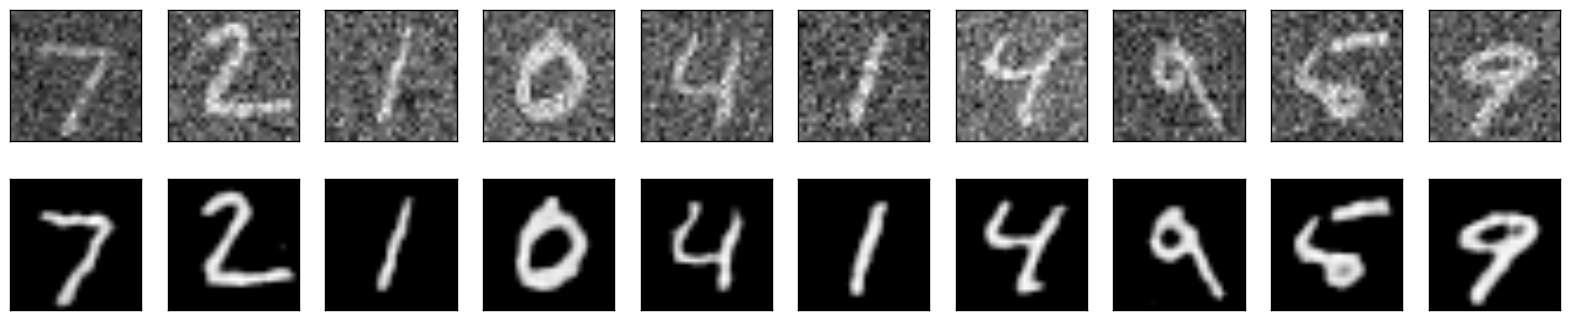

In [7]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.3*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.3*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.5

結果已經有點變得模糊

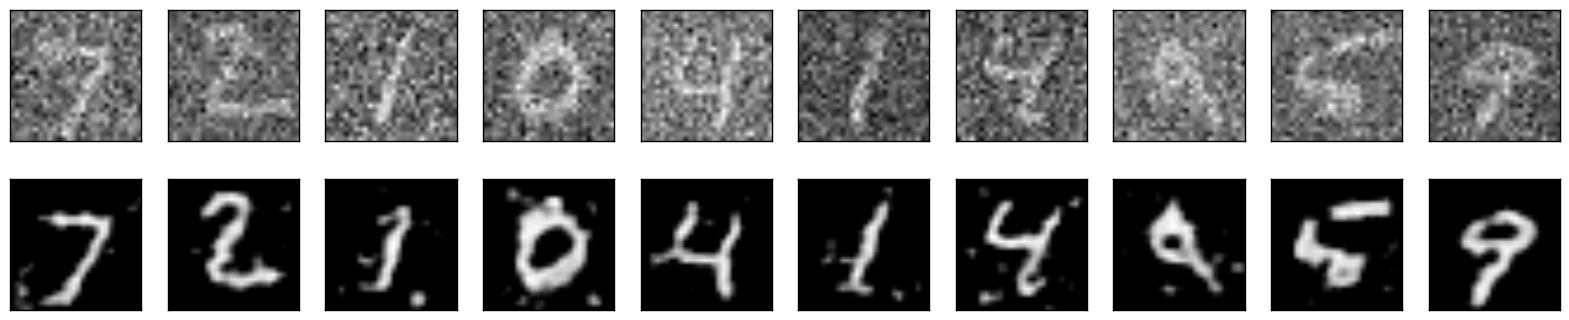

In [8]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.5*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.5*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.7

已經快變認不出來了

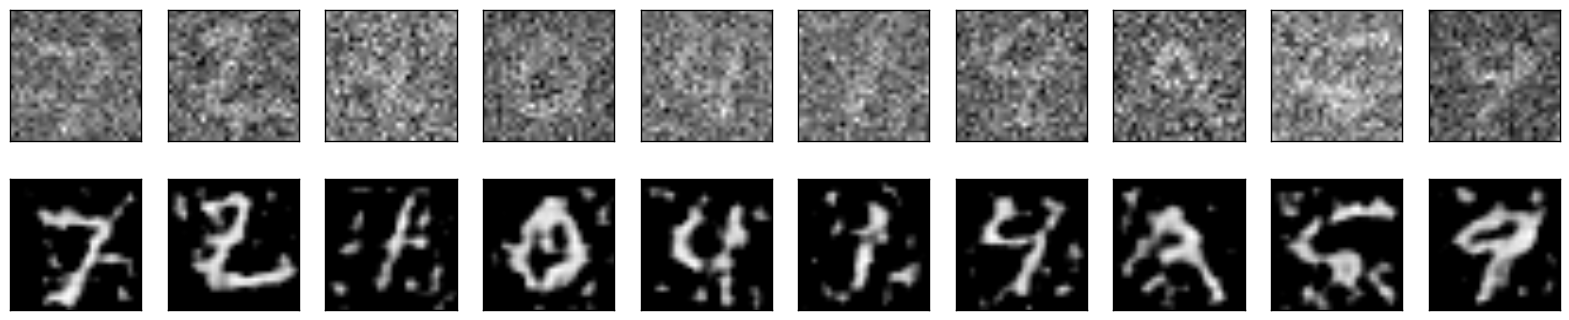

In [9]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.7*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.7*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.9

勉勉強強有一些紋路．

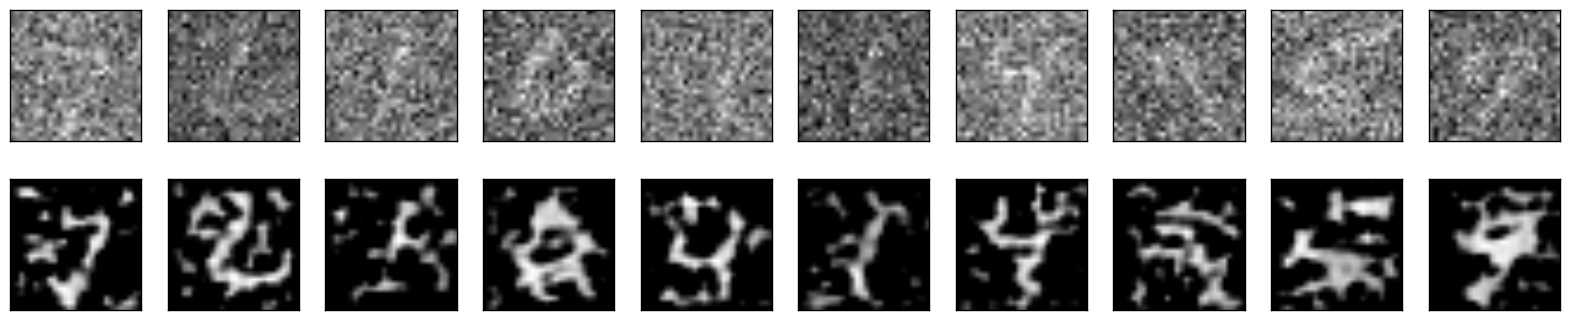

In [10]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.9*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.9*np.random.randn(10, 784), test_reconstruct_img)

### Plot code layer result

觀察中間的 code layer 的結果．

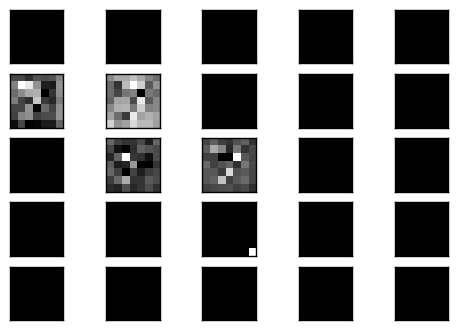

In [11]:
import math
def plot_conv_layer(layer, image, num_filters):
    output = sess.run(layer, feed_dict = {x: [image], x_noise: [image]})
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = output[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
image1 = mnist.test.images[0] + 0.3*np.random.randn(784)
plot_conv_layer(code_layer, image1, 25)

可以看到是部分的 filter 有反應，而反應的 filter 也是模模糊糊的影像，但這樣的輸出經過 decoder 卻可以很漂亮的重建回原來影像．

## Trainging (Add noise with coefficient 0.8)

接下來我們想要挑戰比較困難的使用更模糊的影像來訓練神經網路看看它的結果如何．

In [12]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_noise = tf.placeholder(tf.float32, shape = [None, 784])
x_origin, code_layer, x_reconstruct = build_graph()

cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

sess = tf.InteractiveSession()
batch_size = 50
init_op = tf.global_variables_initializer()
sess.run(init_op)


for epoch in range(10000):
    batch = mnist.train.next_batch(batch_size)
    batch_raw = batch[0]
    batch_noise = batch[0] + 0.8*np.random.randn(batch_size, 784)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch_raw, x_noise: batch_noise})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch_raw, x_noise: batch_noise})))
    
    optimizer.run(feed_dict={x:batch_raw, x_noise: batch_noise})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images, x_noise: mnist.test.images}))

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, ?, ?, ?)
step 0, loss 0.112311
step 100, loss 0.0289463
step 200, loss 0.0289349
step 300, loss 0.0273639
step 400, loss 0.0275356
step 500, loss 0.0253755
step 600, loss 0.0251334
step 700, loss 0.027199
step 800, loss 0.0272284
step 900, loss 0.0243694
step 1000, loss 0.0256118
step 1100, loss 0.025205
step 1200, loss 0.0246229
step 1300, loss 0.0241241
step 1400, loss 0.0257103
step 2000, loss 0.0247174
step 3000, loss 0.0235407
step 4000, loss 0.026623
step 5000, loss 0.0257211
step 6000, loss 0.0246029
step 7000, loss 0.0241382
step 8000, loss 0.0238624
step 9000, loss 0.0230421
final loss 0.0111788


### Reconstructed images with coefficient 0.5

可以看到重建的結果很好．

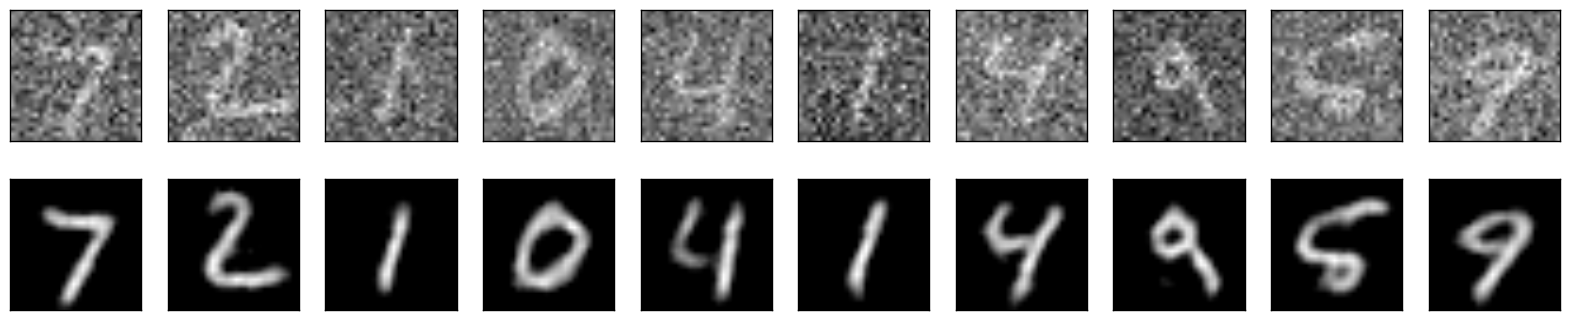

In [13]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.5*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.5*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.8

在係數為 0.8 的情形下，重建出來的影像結果比用 0.3 訓練出來的網路優秀，但是已經開始有些模糊．

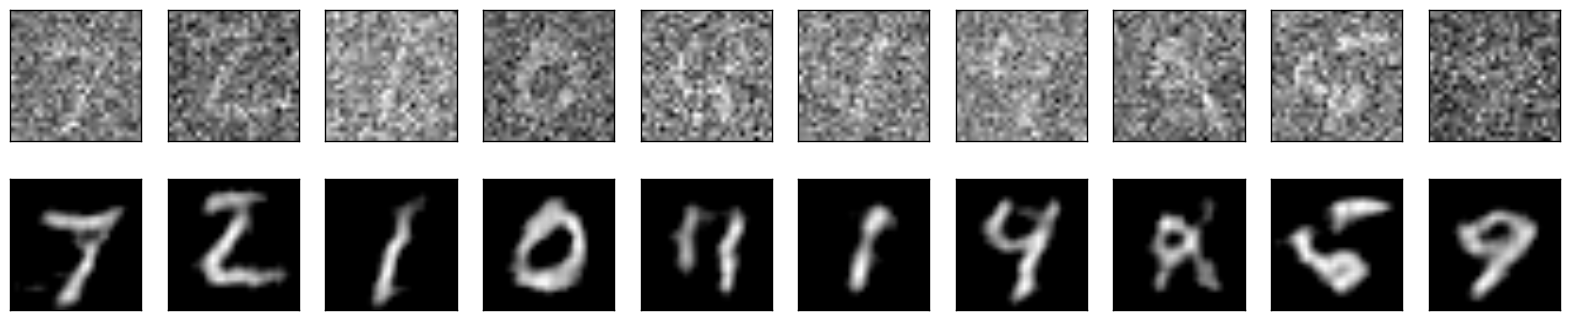

In [14]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.8*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.8*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 0.9

一些數字仍然可以辨認，但有一些變得較糊．

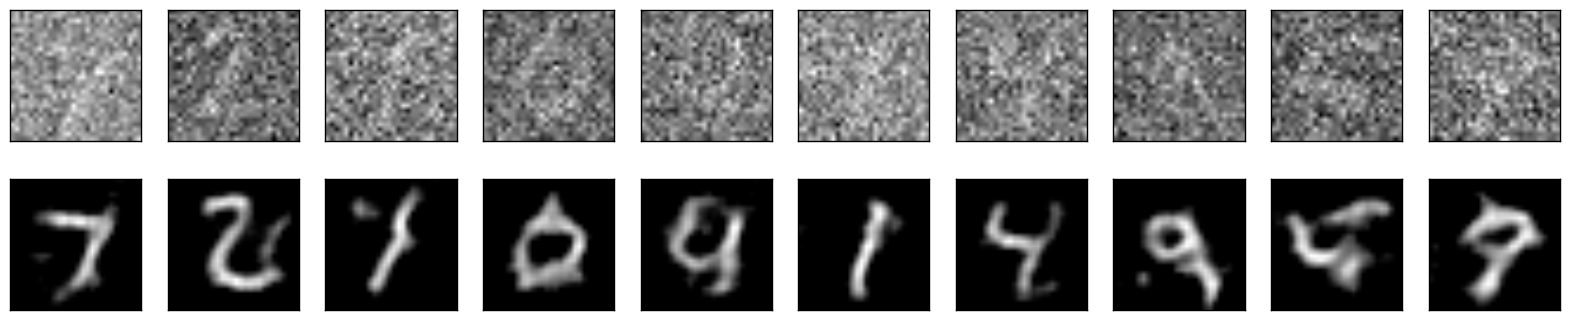

In [15]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 0.9*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 0.9*np.random.randn(10, 784), test_reconstruct_img)

### Reconstructed images with coefficient 1.0

只剩下少數的可以辨認．

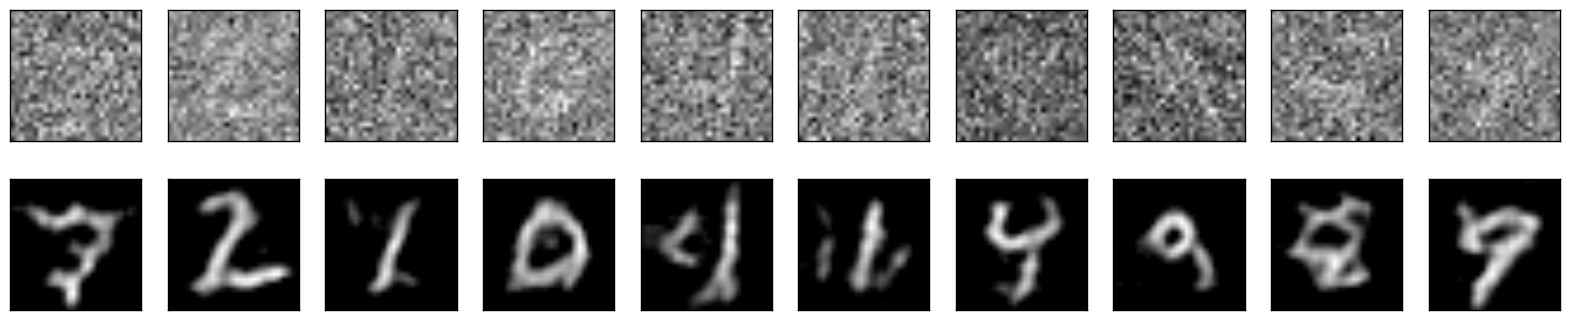

In [16]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img, x_noise: test_origin_img + 1.0*np.random.randn(10, 784)}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img + 1.0*np.random.randn(10, 784), test_reconstruct_img)

## 小結

實作了 `Denoising Autoencoder`，並用不同強度的雜訊來測試，其效果就視覺上看起來還算不錯．

而如果加強了雜訊的強度，期訓練出來的 autoencoder 抗噪的能力也會更好!

### 問題

- 用普通的 autoencoder 來實作，其結果和 convolutional autoencoder 的比較．
- 如果不是輸入噪音影像，而是輸入三分之一，或是四分之一的影像，不知道可不可以還原回來?

## 學習資源連結

[Github Denoising Autoencoder example](https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/dae_mnist_dropout.ipynb)